In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
 
# 分批次训练，一批 64 个
BATCH_SIZE = 64
# 所有样本训练 3 次
EPOCHS = 100
# 学习率设置为 0.0006
LEARN_RATE = 2e-3

# 若当前 Pytorch 版本以及电脑支持GPU，则使用 GPU 训练，否则使用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
 
# 训练集数据加载
train_data = torchvision.datasets.MNIST(
    download=True,
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor()
)
# 构建训练集的数据装载器，一次迭代有 BATCH_SIZE 张图片
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
 
# 测试集数据加载
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
    transform=torchvision.transforms.ToTensor()
)
# 构建测试集的数据加载器，一次迭代 1 张图片，我们一张一张的测试
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle = True)
INPUT_SIZE = 784
HIDE_SIZE_I = 256
HIDE_SIZE_O = 64

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # 隐藏层 1，使用 sigmoid 激活函数
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDE_SIZE_I),
            nn.Sigmoid()
		)
        # 隐藏层 2，使用 sigmoid 激活函数
        self.layer2 = nn.Sequential(
            nn.Linear(HIDE_SIZE_I,HIDE_SIZE_O),
            nn.Sigmoid()
        )
        # 输出层
        self.layer_out = nn.Linear(HIDE_SIZE_O, 10)
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        self.out = self.layer_out(x)
        return self.out

In [4]:
# 实例化DNN，并将模型放在 GPU 训练
model = DNN().to(device)
# 同样，将损失函数放在 GPU
loss_fn = nn.MSELoss(reduction='mean').to(device)
#大数据常用Adam优化器，参数需要model的参数，以及学习率
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
epoch_x = []
acc_y = []
for epoch in range(EPOCHS):
    # 加载训练数据
    model.train()
    for step, data in enumerate(train_loader):
        if step > 15:
            break
        x, y = data
        """
        因为此时的训练集即 x 大小为 （BATCH_SIZE, 1, 28, 28）
        因此这里需要一个形状转换为（BATCH_SIZE, 784）;
		
        y 中代表的是每张照片对应的数字，而我们输出的是 10 个神经元，
        即代表每个数字的概率
        因此这里将 y 也转换为该数字对应的 one-hot形式来表示
        """
        x = x.view(x.size(0), 784)
        yy = np.zeros((x.size(0), 10))
        for j in range(x.size(0)):
            yy[j][y[j].item()] = 1
        yy = torch.from_numpy(yy)
        yy = yy.float()
        x, yy = x.to(device), yy.to(device)
 
        # 调用模型预测
        output = model(x).to(device)
        # 计算损失值
        loss = loss_fn(output, yy)
        # 输出看一下损失变化
#         print(f'EPOCH({epoch})   loss = {loss.item()}')
        # 每一次循环之前，将梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 梯度下降，更新参数
        optimizer.step()
    sums = 0
    alls = 0
    model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        # 这里 仅对 x 进行处理
        x = x.view(x.size(0), 784)
        x, y = x.to(device), y.to(device)
        res = model(x).to(device)
        # 得到 模型预测值
        r = torch.argmax(res,dim = 1)
        # 标签，即真实值
        sums += torch.sum(r == y).item()
        alls += r.size()[0]
    print('epoch {} valid accuracy：'.format(epoch), sums / alls)
    epoch_x.append(epoch)
    acc_y.append(sums/alls)
# test：

epoch 0 valid accuracy： 0.2794
epoch 1 valid accuracy： 0.5723
epoch 2 valid accuracy： 0.6876
epoch 3 valid accuracy： 0.7412
epoch 4 valid accuracy： 0.7902
epoch 5 valid accuracy： 0.8198
epoch 6 valid accuracy： 0.8345
epoch 7 valid accuracy： 0.844
epoch 8 valid accuracy： 0.8488
epoch 9 valid accuracy： 0.8525
epoch 10 valid accuracy： 0.8566
epoch 11 valid accuracy： 0.86
epoch 12 valid accuracy： 0.8642
epoch 13 valid accuracy： 0.8682
epoch 14 valid accuracy： 0.8717
epoch 15 valid accuracy： 0.8746
epoch 16 valid accuracy： 0.8775
epoch 17 valid accuracy： 0.88
epoch 18 valid accuracy： 0.8827
epoch 19 valid accuracy： 0.8839
epoch 20 valid accuracy： 0.8853
epoch 21 valid accuracy： 0.8872
epoch 22 valid accuracy： 0.8873
epoch 23 valid accuracy： 0.8884
epoch 24 valid accuracy： 0.8886
epoch 25 valid accuracy： 0.8899
epoch 26 valid accuracy： 0.89
epoch 27 valid accuracy： 0.8898
epoch 28 valid accuracy： 0.8903
epoch 29 valid accuracy： 0.8905
epoch 30 valid accuracy： 0.8903
epoch 31 valid accuracy： 

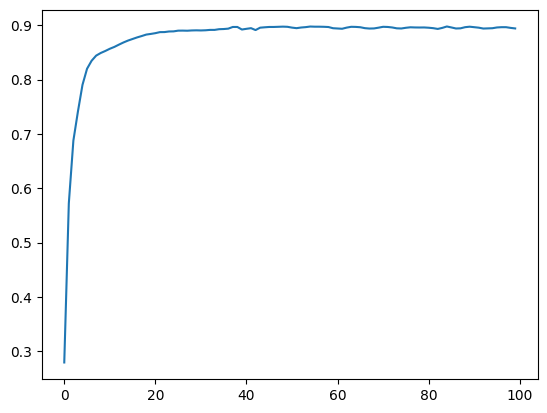

In [5]:
temp = pd.DataFrame()
temp['epcoh'] = epoch_x
temp['acc'] = acc_y
temp.to_excel('DNN_Acc_WithOut_Dropout_Epoch{}_Batch{}_Lr{}_Max{}_{}-{}-{}.xlsx'.format(EPOCHS,BATCH_SIZE,LEARN_RATE,max(acc_y),INPUT_SIZE,HIDE_SIZE_I, HIDE_SIZE_O),index = False)
plt.plot(epoch_x,acc_y)

In [6]:
class DNN_Dropout(nn.Module):
    def __init__(self,rate):
        super(DNN_Dropout, self).__init__()
        # 隐藏层 1，使用 sigmoid 激活函数
        self.layer1 = nn.Sequential(
            nn.Dropout(p=rate),
            nn.Linear(INPUT_SIZE, HIDE_SIZE_I),
            nn.Sigmoid()
		)
        # 隐藏层 2，使用 sigmoid 激活函数
        self.layer2 = nn.Sequential(
            nn.Linear(HIDE_SIZE_I,HIDE_SIZE_O),
            nn.Sigmoid()
        )
        # 输出层
        self.layer_out = nn.Linear(HIDE_SIZE_O, 10)
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        self.out = self.layer_out(x)
        return self.out

In [7]:
# 实例化DNN，并将模型放在 GPU 训练
for droppout in range(1,10):
    model = DNN_Dropout(droppout/10).to(device)
    # 同样，将损失函数放在 GPU
    loss_fn = nn.MSELoss(reduction='mean').to(device)
    #大数据常用Adam优化器，参数需要model的参数，以及学习率
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
    dropout_list = []
    acc_list = []
    for epoch in range(EPOCHS):
        # 加载训练数据
        model.train()
        for step, data in enumerate(train_loader):
            if step > 15:
                break
            x, y = data
            """
            因为此时的训练集即 x 大小为 （BATCH_SIZE, 1, 28, 28）
            因此这里需要一个形状转换为（BATCH_SIZE, 784）;

            y 中代表的是每张照片对应的数字，而我们输出的是 10 个神经元，
            即代表每个数字的概率
            因此这里将 y 也转换为该数字对应的 one-hot形式来表示
            """
            x = x.view(x.size(0), 784)
            yy = np.zeros((x.size(0), 10))
            for j in range(x.size(0)):
                yy[j][y[j].item()] = 1
            yy = torch.from_numpy(yy)
            yy = yy.float()
            x, yy = x.to(device), yy.to(device)

            # 调用模型预测
            output = model(x).to(device)
            # 计算损失值
            loss = loss_fn(output, yy)
            # 输出看一下损失变化
    #         print(f'EPOCH({epoch})   loss = {loss.item()}')
            # 每一次循环之前，将梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 梯度下降，更新参数
            optimizer.step()
        sums = 0
        alls = 0
        max_acc = 0
        model.eval()
        for i, data in enumerate(test_loader):
            x, y = data
            # 这里 仅对 x 进行处理
            x = x.view(x.size(0), 784)
            x, y = x.to(device), y.to(device)
            res = model(x).to(device)
            # 得到 模型预测值
            r = torch.argmax(res,dim = 1)
            # 标签，即真实值
            sums += torch.sum(r == y).item()
            alls += r.size()[0]
        if sums / alls > max_acc:
            max_acc = sums / alls
        dropout_list.append(droppout/10)
        acc_list.append(max_acc)
    print('Dropout {} max valid accuracy：'.format(droppout/10),max_acc)
# test：

Dropout 0.1 max valid accuracy： 0.9006
Dropout 0.2 max valid accuracy： 0.9067
Dropout 0.3 max valid accuracy： 0.9086
Dropout 0.4 max valid accuracy： 0.9066
Dropout 0.5 max valid accuracy： 0.909
Dropout 0.6 max valid accuracy： 0.9075
Dropout 0.7 max valid accuracy： 0.9074
Dropout 0.8 max valid accuracy： 0.8915
Dropout 0.9 max valid accuracy： 0.8535


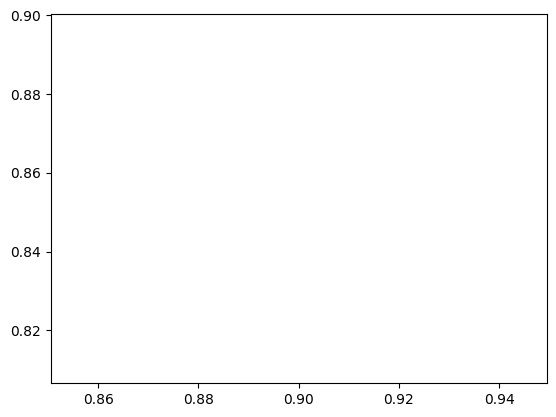

In [10]:
temp = pd.DataFrame()
temp['drop_rate'] = dropout_list
temp['acc'] = acc_list
temp.to_excel('DNN_Acc_With_Dropout_Epoch{}_Batch{}_Lr{}_Max{}_{}-{}-{}.xlsx'.format(EPOCHS,BATCH_SIZE,LEARN_RATE,max(acc_list),INPUT_SIZE,HIDE_SIZE_I, HIDE_SIZE_O),index = False)
plt.plot(dropout_list,acc_list)

In [12]:
dropout_list = []
acc_list = []
for i in range(1,10):
    dropout_list.append(i/10)
acc_list.append(0.9006
acc_list.append(0.9067
acc_list.append(0.9086
acc_list.append(0.9066
acc_list.append(0.909
acc_list.append(0.9075
acc_list.append(0.9074
acc_list.append(0.8915
0.8535

In [ ]:
0.9006
0.9067
0.9086
0.9066
0.909
0.9075
0.9074
0.8915
0.8535